# Machine Learning Training Pipeline: Masked Autoencoder on Dataset with Missing Values

This notebook demonstrates the machine learning (ML) training pipeline using a two-stage modeling approach: a Masked Autoencoder (MAE) as a pre-training model, followed by a classifier. The focus is on addressing the task of **Rare Event Early Detection**: Sepsis Onset for Critically Ill Trauma Patients in the Post-Traumatic Sepsis dataset, which contains missing values.

This task presents two main challenges:

1. **Handling Missing Values:** Traditional classifiers often struggle with input data containing missing values, which are prevalent in this dataset.
  
2. **Class Imbalance:** The dataset suffers from significant class imbalance, with positive samples (sepsis onset) representing approximately 4% of the data.

The Masked Autoencoder (MAE) approach offers a solution to these challenges. Previous works in natural language processing (NLP) [1] and computer vision (CV) [2] have demonstrated that MAEs can effectively learn feature representations and reconstruct models even in the presence of missing values. Additionally, the masking process itself can serve as a form of data augmentation, introducing less noise compared to traditional augmentation methods, which can sometimes degrade model performance.

### References:
1. **Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K.** (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. *Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers)*, 4171-4186.
   
2. **He, K., Chen, X., Xie, S., Li, Y., Dollár, P., & Girshick, R.** (2022). Masked Autoencoders Are Scalable Vision Learners. *Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*, 16000-16009.


# 0. Environment Setup

## Mount Google Drive

To access the GitHub project and associated files, you need to mount your Google Drive to Colab. This process allows you to read and write files directly from your Google Drive within the Colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set your parameters

Please make sure to update the following parameters to your own:

- **Project ID**: The BigQuery project ID to query the MIMIC-III v1.4 raw data. (If you're not sure what your project ID is, check details in `notebooks/MIMIC_III_Data_Access_Instructions.ipynb`.)
- **BASE_PATH**: The path where the GitHub project will be cloned.

In [ ]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/PTSM_Private_Testing"

## Importing libraries.

In [ ]:
%cd {BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII
# basic
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# for model
import math
import keras
import tensorflow as tf
# import keras.backend as K
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.keras.utils import to_categorical

# for training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

# for dataset
from scripts.early_sepsis_onset_detection_setup import dataset_construction

# Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII')

/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII


# Load Dataset

In this section, we will load the complete Post-Traumatic Sepsis dataset (without missing values), which is derived from the MIMIC-III v1.4 dataset. For a comprehensive explanation of the dataset construction and additional relevant information, please refer to the `notebooks/Early_Sepsis_Onset_Detection_Setup.ipynb` file.

The dataset table comprises the following columns:

- **Temporal Features**: Multivariate time-series input data with dimensions (# of timestamps, # of features).
- **Label**: Binary value (0 or 1) representing the output label.
- **Dataset**: Indicates whether the instance is part of the training or test set.

Each row in the dataset corresponds to one nighttime instance, and includes patient identifiers (`subject_id`, `hadm_id`) and a timestamp ID (`Date`, `Night`).




In [ ]:
# Check if the file exists
file_path = project_path_obj.dataset_with_nan_path
if os.path.exists(file_path):
    # Load the existing file
    data_with_nan_df = pd.read_pickle(file_path)
else:
    data_with_nan_df, data_wo_nan_df = dataset_construction(project_path_obj, PROJECT_ID, is_report=True)
data_with_nan_df.head()

,subject_id,hadm_id,Date,Night,Temporal Features,Label,Dataset
1,43,146828,2186-10-02,2,"[[90.0, 147.0, 77.0, 100.33300018310548, 25.0,...",0,train
2,43,146828,2186-10-03,3,"[[95.0, 130.0, 71.0, 86.5, 16.0, nan, 100.0, n...",0,train
3,43,146828,2186-10-04,4,"[[96.0, 117.0, 65.0, 81.0, 17.0, 36.8333350287...",0,train
4,43,146828,2186-10-05,5,"[[96.0, 127.0, 78.0, 92.0, 16.0, nan, 100.0, n...",0,train
6,141,168006,2140-11-07,2,"[[89.0, 163.0, 68.0, 95.0, 18.5, nan, 100.0, 8...",0,train


In [ ]:
train_df = data_with_nan_df[data_with_nan_df['Dataset'] == 'train']
test_df = data_with_nan_df[data_with_nan_df['Dataset'] == 'test']
train_imbalance_ratio = round(train_df.Label.sum() / len(train_df), 5)
test_imbalance_ratio = round(test_df.Label.sum() / len(test_df), 5)
print(f"Train dataset shape: {train_df.shape} with imbalance ratio {train_imbalance_ratio}")
print(f"Test dataset shape: {test_df.shape} with imbalance ratio {test_imbalance_ratio}")

Train dataset shape: (9316, 7) with imbalance ratio 0.04219
Test dataset shape: (1249, 7) with imbalance ratio 0.04644


## Mask Generation

In [ ]:
def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked
    Returns:
        (L,) boolean numpy array intended to mask ('drop') with 0s a sequence of length L
    """
    # np.random.seed(seed)
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask

def noise_mask(X, masking_ratio, lm=3, mode='separate', distribution='geometric', exclude_feats=None):
    """
    Creates a random boolean mask of the same shape as X, with 0s at places where a feature should be masked.
    Args:
        X: (seq_length, feat_dim) numpy array of features corresponding to a single sample
        masking_ratio: proportion of seq_length to be masked. At each time step, will also be the proportion of
            feat_dim that will be masked on average
        lm: average length of masking subsequences (streaks of 0s). Used only when `distribution` is 'geometric'.
        mode: whether each variable should be masked separately ('separate'), or all variables at a certain positions
            should be masked concurrently ('concurrent')
        distribution: whether each mask sequence element is sampled independently at random, or whether
            sampling follows a markov chain (and thus is stateful), resulting in geometric distributions of
            masked squences of a desired mean length `lm`
        exclude_feats: iterable of indices corresponding to features to be excluded from masking (i.e. to remain all 1s)
    Returns:
        boolean numpy array with the same shape as X, with 0s at places where a feature should be masked
    """
    # np.random.seed(seed)
    if exclude_feats is not None:
        exclude_feats = set(exclude_feats)

    if distribution == 'geometric':  # stateful (Markov chain)
        if mode == 'separate':  # each variable (feature) is independent
            mask = np.ones(X.shape, dtype=bool)
            for m in range(X.shape[1]):  # feature dimension
                if exclude_feats is None or m not in exclude_feats:
                    mask[:, m] = geom_noise_mask_single(X.shape[0], lm, masking_ratio)  # time dimension
        else:  # replicate across feature dimension (mask all variables at the same positions concurrently)
            mask = np.tile(np.expand_dims(geom_noise_mask_single(X.shape[0], lm, masking_ratio), 1), X.shape[1])
    else:  # each position is independent Bernoulli with p = 1 - masking_ratio
        if mode == 'separate':
            mask = np.random.choice(np.array([True, False]), size=X.shape, replace=True,
                                    p=(1 - masking_ratio, masking_ratio))
        else:
            mask = np.tile(np.random.choice(np.array([True, False]), size=(X.shape[0], 1), replace=True,
                                            p=(1 - masking_ratio, masking_ratio)), X.shape[1])

    return mask

def Gen_Mask(X, r=0.15, lm=2):
  '''
  Gen mask Matrix for a given training sample
  '''
  M = noise_mask(X, r, lm, mode='separate', distribution='geometric', exclude_feats=None)
  M = np.where(M, 1, 0)
  return M

def Gen_Masked_data(X, M):
  '''
  Gen mask input Matrix as target for lossfunction for training process
  '''
  Y = np.multiply(X, np.subtract(1, M))
  return Y

def Gen_Unmask_Data(X, M):
  '''
  Gen un-mask Matrix for training process
  '''
  X = np.multiply(X,M)
  return X

##  Data Preparation for Training

In [ ]:
def gen_MaskSampling_train(train, mask_r):
    """Generates masked training data, with oversampling for anomaly data."""
    train_anomaly = train[train.Label == 1]
    train_normal = train[train.Label == 0]

    # Oversample the anomaly data
    num_oversample = train_normal.shape[0]
    # print("num_oversample:", num_oversample)
    train_anomaly = train_anomaly.sample(num_oversample, replace=True, random_state=88)
    train = pd.concat([train_anomaly, train_normal], ignore_index=True)

    # Shuffle and apply MASK strategy
    train = shuffle(train).reset_index(drop=True)
    train = train.rename({'Temporal Features': "InputFeatures"}, axis=1)
    train['Mask'] = train['InputFeatures'].apply(Gen_Mask, r=mask_r)
    train['mask_X'] = train.apply(lambda x: Gen_Unmask_Data(x.InputFeatures, x.Mask), axis=1)
    train['mask_Y'] = train.apply(lambda x: Gen_Masked_data(x.InputFeatures, x.Mask), axis=1)
    return train

def gen_MaskSampling_val(val, mask_r=None, isOversampling=True):
    """Generates masked validation data, with optional oversampling for anomaly data."""
    if isOversampling:
        anomaly = val[val.Label == 1]
        normal = val[val.Label == 0]
        num_oversample = normal.shape[0]
        # print("num_oversample:", num_oversample)
        anomaly = anomaly.sample(num_oversample, replace=True, random_state=88)
        val = pd.concat([anomaly, normal], ignore_index=True)

    # Apply MASK strategy
    if mask_r is not None:
        val = shuffle(val).reset_index(drop=True)
        val = val.rename({'Temporal Features': "InputFeatures"}, axis=1)
        val['Mask'] = val['InputFeatures'].apply(Gen_Mask, r=mask_r)
        val['mask_X'] = val.apply(lambda x: Gen_Unmask_Data(x.InputFeatures, x.Mask), axis=1)
        val['mask_Y'] = val.apply(lambda x: Gen_Masked_data(x.InputFeatures, x.Mask), axis=1)
    return val

def data_process(train_df, val_df):
    """Processes the training and validation data into appropriate numpy arrays."""
    X = np.stack(train_df['InputFeatures'])
    mask = np.stack(train_df['Mask'])
    Y = to_categorical(train_df['Label'], 2)

    # Adjust mask for NaN values
    isna_index = np.isnan(X)
    mask[isna_index] = 0

    # Validation data
    X_val = np.stack(val_df['InputFeatures'])
    mask_val = np.ones(X_val.shape)  # No mask for validation data
    Y_val = to_categorical(val_df['Label'], 2)

    isna_val = np.isnan(X_val)
    mask_val[isna_val] = 0
    return (X, mask, Y), (X_val, mask_val, Y_val)

def prepare_data_for_training(dataset, sepsis_patient_df, train_index, val_index, metrics, mask_rate=0.15):
    """
    Splits the dataset based on patient IDs into training and validation sets, applies masking,
    and processes the data for training. Updates the provided metrics dictionary with data statistics.

    Args:
        sepsis_patient_df (DataFrame): DataFrame containing patient information.
        train_index (array-like): Indices for training patients.
        val_index (array-like): Indices for validation patients.
        dataset (DataFrame): The full dataset containing features and patient IDs.
        MASK_RATE (float): The masking rate for generating masked data.
        metrics (dict): Dictionary to store metrics for number of samples and patients.

    Returns:
        tuple: Processed training and validation data as tuples:
               (X_train, mask_train, Y_train), (X_val, mask_val, Y_val)
    """
    # Split based on patient IDs
    train_id = sepsis_patient_df.loc[train_index, :]
    val_id = sepsis_patient_df.loc[val_index, :]
    train_df = dataset[dataset.subject_id.isin(train_id.subject_id)]
    val_df = dataset[dataset.subject_id.isin(val_id.subject_id)]

    # Preprocess: Generate Mask and extract X & y
    train_df = gen_MaskSampling_train(train_df, mask_rate)
    val_df = gen_MaskSampling_val(val_df, mask_r=mask_rate, isOversampling=False)  # Without mask for validation
    (X_train, mask_train, y_train), (X_val, mask_val, y_val) = data_process(train_df, val_df)

    # Update metrics
    metrics['num_train_sample'].append(X_train.shape[0])
    metrics['num_train_patient'].append(train_id.shape[0])
    metrics['num_val_sample'].append(X_val.shape[0])
    metrics['num_val_patient'].append(val_id.shape[0])

    # Print statistics
    train_imbalance_ratio = round(train_df.Label.sum() / len(train_df), 5)
    val_imbalance_ratio = round(val_df.Label.sum() / len(val_df), 5)
    print(f"Train: \t\t{X_train.shape[0]} samples for {train_id.shape[0]} patients with imbalance ratio {train_imbalance_ratio}")
    print(f"Validation: \t{X_val.shape[0]} samples for {val_id.shape[0]} patients with imbalance ratio {val_imbalance_ratio}")

    return (X_train, mask_train, y_train), (X_val, mask_val, y_val)


# Model



## Model Definition

In [ ]:
from keras import layers, models, Input
from keras.regularizers import l2

def Encoder_model(T, F, drop_r=0.2):
    input_layer = Input(shape=(T, F))
    x = layers.Masking(mask_value=-1.0)(input_layer)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    enc_output = layers.LSTM(units=64, return_sequences=False, kernel_regularizer=l2(0.01))(x)
    return models.Model(input_layer, enc_output, name="encoder")

def Decoder_model(T, F, drop_r=0.2):
    latent_inputs = Input(shape=(64,))
    x = layers.RepeatVector(n=T)(latent_inputs)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    dec_output = layers.TimeDistributed(layers.Dense(units=F, kernel_regularizer=l2(0.01)))(x)
    return models.Model(latent_inputs, dec_output, name="decoder")

def AutoEncoder_model(T, F, drop_r=0.2):
    inputs = Input(shape=(T, F))
    encoder = Encoder_model(T, F, drop_r=drop_r)
    decoder = Decoder_model(T, F, drop_r=drop_r)
    autoencoder = models.Model(inputs, decoder(encoder(inputs)), name="autoencoder")
    return encoder, decoder, autoencoder

# Instantiate the models
encoder, decoder, autoencoder = AutoEncoder_model(9, 9, drop_r=0.2)

# Print summary of the autoencoder model
encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 9, 9)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_1 (Masking)       │ (None, 9, 9)           │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 9, 9)           │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 9, 9)           │             18 │ masking_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_1 (Any)               │ (None, 9)              │              0 │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 9, 128)         │         70,656 │ layer_normalization_3… │
│                           │                        │                │ any_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 9, 128)         │            512 │ lstm_4[0][0],          │
│ (BatchNormalization)      │                        │                │ any_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 9, 128)         │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 64)             │         49,408 │ dropout_5[0][0],       │
│                           │                        │                │ any_1[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 120,594 (471.07 KB)

 Trainable params: 120,338 (470.07 KB)

 Non-trainable params: 256 (1.00 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_4                │ (None, 9, 64)               │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 9, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 9, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 9, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 9, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 9, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 9, 9)                │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,897 (523.04 KB)

 Trainable params: 133,513 (521.54 KB)

 Non-trainable params: 384 (1.50 KB)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 9, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 64)                  │         120,594 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 9, 9)                │         133,897 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,491 (994.11 KB)

 Trainable params: 253,851 (991.61 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
def classification(input_shape, encoder, mlp_units=[32], mlp_dropout_rate=0.5, regularizers_l2=1e-5):
    """
    Builds a classification model using a pre-trained encoder followed by fully connected layers.

    Args:
        input_shape (tuple): Shape of the input data (excluding batch size).
        encoder (Model): Pre-trained encoder model to extract features.
        mlp_units (list): List of integers defining the units in the MLP layers.
        mlp_dropout_rate (float): Dropout rate for the MLP layers.
        regularizers_l2 (float): L2 regularization factor for the Dense layers.

    Returns:
        Model: A Keras Model instance for classification.
    """
    inputs = Input(shape=input_shape)

    # Encoder
    x = encoder(inputs)
    x = layers.Dropout(mlp_dropout_rate)(x)

    # Fully connected layers
    x = layers.LayerNormalization()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu", kernel_regularizer=l2(regularizers_l2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(mlp_dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(2, activation="softmax")(x)

    model = models.Model(inputs, outputs, name='downstream')
    return model

input_shape = (9, 9) #T, F
classification_model = classification(input_shape, encoder)
classification_model.summary()

Model: "downstream"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 9, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 64)                  │         120,594 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,996 (480.45 KB)

 Trainable params: 122,676 (479.20 KB)

 Non-trainable params: 320 (1.25 KB)

## Custom Fit and Loss Functions

In [ ]:
def element_wise_weight_mae(y_true, y_pred, weights=None):
    """
    Computes the Mean Absolute Error (MAE) between the true and predicted values.
    Ignores NaN values in y_true and y_pred.

    Args:
        y_true (Tensor): Ground truth values.
        y_pred (Tensor): Predicted values.
        weights (Tensor, optional): Weights for each element in the loss calculation. Defaults to None.

    Returns:
        Tensor: Mean Absolute Error, optionally weighted, with NaNs ignored.
    """
    # Create a mask to exclude NaN values
    # mask = ~tf.math.is_nan(y_true) #& ~tf.math.is_nan(y_pred)
    mask = ~tf.equal(y_true, -1.0)

    # Apply mask to y_true, y_pred, and weights
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    if weights is not None:
        weights_masked = tf.boolean_mask(weights, mask)
        return K.mean(K.abs(y_true_masked - y_pred_masked) * weights_masked)
    else:
        mae = tf.keras.losses.MeanAbsoluteError()
        return mae(y_true_masked, y_pred_masked)
# Example usage
y_true = tf.constant([[[3.0, 5.0, -1], [7.0, -1, 6.0]]])
y_pred = tf.constant([[[2.0, 6.0, 4.0], [8.0, 3.5, 7.0]]])
weights = tf.constant([[[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]]])
# With weights
weighted_mae = element_wise_weight_mae(y_true, y_pred, weights)
print(f"Weighted MAE: {weighted_mae.numpy()}") # 0.5
# Without weights
unweighted_mae = element_wise_weight_mae(y_true, y_pred)
print(f"Unweighted MAE: {unweighted_mae.numpy()}") # 1

class WeightedMaskAutoEncFit(keras.Model):
    #inherit from keras.model
    #by default only the mask out part contribute to final decision
    def __init__(self, model, mask_weight_para=0.8):
        super(WeightedMaskAutoEncFit, self).__init__()
        self.model = model
        self.mask_weight_para = mask_weight_para

    def compile(self, optimizer, loss):
        super(WeightedMaskAutoEncFit, self).compile()
        self.optimizer = optimizer
        self.loss = loss

    def train_step(self, data):
        # Unpack the data
        x, m = data
        m = tf.cast(m, tf.float32)

        # forward propagation
        with tf.GradientTape() as tape:
            # Caclulate predictions
            y_pred = self.model( x * m , training=True)
            # Loss with elements wise weight
            if self.mask_weight_para != None:
              mask_weight = m * (1-self.mask_weight_para) + (1- m) * self.mask_weight_para
              loss = self.loss(x, y_pred, mask_weight)
            else:
              loss = self.loss(x, y_pred, weights=None)

        # Gradients
        training_vars = self.trainable_variables
        gradients = tape.gradient(loss, training_vars)

        # Step with optimizer
        self.optimizer.apply_gradients(zip(gradients, training_vars))

        return {"loss": loss }

    def test_step(self, data):
        # Unpack the data
        # not using mask
        x, m = data

        # Compute predictions
        y_pred = self.model(x, training=False)

        # Updates the metrics tracking the loss
        # For tesing process of each epoch,
        # we want to evaluate how they can reconstract the whole dataset
        loss = self.loss(x, y_pred)

        return {"val loss": loss }


Weighted MAE: 0.5
Unweighted MAE: 1.0


## Evaluation and Learning Curve Plotting Function

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
def evaluate_model(y_true, y_pred_probs, metrics):
    """
    Evaluates the model's performance using various metrics and updates the metrics dictionary.

    Parameters:
    - y_true: True labels (numpy array or list).
    - y_pred_probs: Predicted probabilities (numpy array).
    - metrics: Dictionary to update with evaluation metrics.

    Returns:
    - None
    """
    # Convert probabilities to binary predictions
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_pr = roc_auc_score(y_true, y_pred_probs[:, 1])
    specificity = recall_score(y_true, y_pred, pos_label=0)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Append metrics
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1_score'].append(f1)
    metrics['auc(PR)'].append(auc_pr)
    metrics['specificity'].append(specificity)
    metrics['tn'].append(tn)
    metrics['fp'].append(fp)
    metrics['fn'].append(fn)
    metrics['tp'].append(tp)

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_pr': auc_pr,
        'specificity': specificity,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }

# Define the function to plot learning curves
def plot_learning_curves(history, val_loss_name='val_loss'):
    """
    Plot the learning curves for training and validation loss/accuracy.

    Parameters:
    - history: The history object returned from model.fit.

    Returns:
    - None
    """
    # Extract metrics from the history object
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot training & validation loss values
    plt.figure(figsize=(4, 3))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history[val_loss_name], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training with 5-Fold Cross-Validation


Fold 1 training...
Train: 		14158 samples for 1085 patients with imbalance ratio 0.5
Validation: 	1923 samples for 272 patients with imbalance ratio 0.04108
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - loss: 22.1820 - val_val loss: 76.4427
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 21.3106 - val_val loss: 83.4859
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 19.6733 - val_val loss: 89.4860
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - loss: 17.2601 - val_val loss: 99.7312
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 14.4143 - val_val loss: 65.4544
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - loss: 11.5619 - val_val loss: 57.9902
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - loss: 8.9998 - val_val loss: 30.3193
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 6.9852 - val_val loss: 19.2311
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 5.5689 - val_val loss: 13.1765

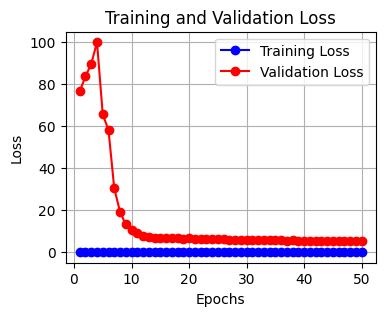

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Epoch 1/200
443/443 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - auc_2: 0.4911 - loss: 3.3063 - precision_2: 0.4938 - recall_2: 0.4938 - val_auc_2: 0.3354 - val_loss: 3.1007 - val_precision_2: 0.1934 - val_recall_2: 0.1934
Epoch 2/200
443/443 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - auc_2: 0.5025 - loss: 3.1687 - precision_2: 0.5009 - recall_2: 0.5009 - val_auc_2: 0.3377 - val_loss: 2.9794 - val_precision_2: 0.2033 - val_recall_2: 0.2033
Epoch 3/200
443/443 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - auc_2: 0.4973 - loss: 3.0615 - precision_2: 0.4958 - recall_2: 0.4958 - val_auc_2: 0.3366 - val_loss: 2.8728 - val_precision_2: 0.1903 - val_recall_2: 0.1903
Epoch 4/200
443/443 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - auc_2: 0.5026 - loss: 2.9436 - precision_2: 0.5011 - recall_2: 0.5011 - val_auc_2: 0.3386 - val_loss: 2.7720 - val_precision_2: 0.1898 - val_recall_2: 0.1898
Epoch 5/200
443/443 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - auc_2: 0.5094 - loss: 2.8317 - precision_2:

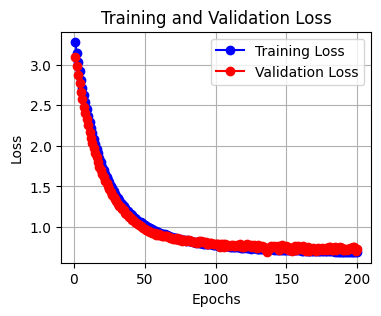


Fold 2 training...
Train: 		14178 samples for 1085 patients with imbalance ratio 0.5
Validation: 	1913 samples for 272 patients with imbalance ratio 0.0413
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - loss: 22.1452 - val_val loss: 79.1568
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 21.1461 - val_val loss: 84.8850
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 19.3740 - val_val loss: 81.6083
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 16.8878 - val_val loss: 88.7196
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 14.0220 - val_val loss: 65.9044
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 11.1826 - val_val loss: 42.4436
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 8.6263 - val_val loss: 36.8706
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 6.7373 - val_val loss: 27.2041
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 5.3526 - val_val loss: 17.8616


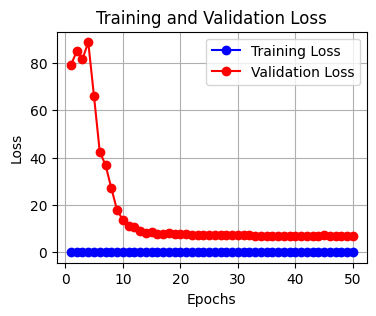

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Epoch 1/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - auc_3: 0.5137 - loss: 3.2815 - precision_3: 0.5089 - recall_3: 0.5089 - val_auc_3: 0.4519 - val_loss: 3.0818 - val_precision_3: 0.3617 - val_recall_3: 0.3617
Epoch 2/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - auc_3: 0.5134 - loss: 3.1840 - precision_3: 0.5103 - recall_3: 0.5103 - val_auc_3: 0.4431 - val_loss: 3.0042 - val_precision_3: 0.3502 - val_recall_3: 0.3502
Epoch 3/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - auc_3: 0.5135 - loss: 3.0838 - precision_3: 0.5176 - recall_3: 0.5176 - val_auc_3: 0.4588 - val_loss: 2.9061 - val_precision_3: 0.3738 - val_recall_3: 0.3738
Epoch 4/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - auc_3: 0.5222 - loss: 2.9925 - precision_3: 0.5186 - recall_3: 0.5186 - val_auc_3: 0.4578 - val_loss: 2.8237 - val_precision_3: 0.3727 - val_recall_3: 0.3727
Epoch 5/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - auc_3: 0.5199 - loss: 2.9114 - precision_3:

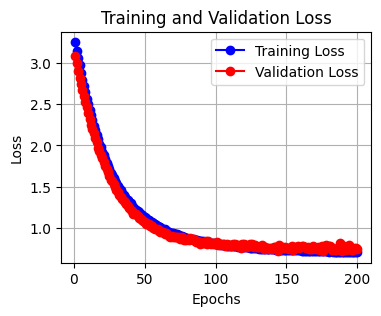


Fold 3 training...
Train: 		14206 samples for 1086 patients with imbalance ratio 0.5
Validation: 	1898 samples for 271 patients with imbalance ratio 0.0411
Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - loss: 22.2186 - val_val loss: 77.7851
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 21.2001 - val_val loss: 83.9744
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 19.3865 - val_val loss: 92.0109
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 16.8591 - val_val loss: 90.8821
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 14.0154 - val_val loss: 63.8493
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 11.1428 - val_val loss: 40.2496
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 8.5937 - val_val loss: 26.5851
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 6.6909 - val_val loss: 19.6744
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 5.4262 - val_val loss: 13.5195

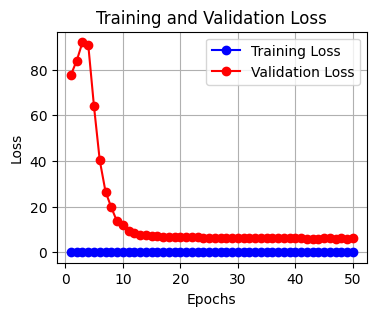

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
Epoch 1/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - auc_4: 0.5131 - loss: 3.3985 - precision_4: 0.5154 - recall_4: 0.5154 - val_auc_4: 0.3989 - val_loss: 3.1262 - val_precision_4: 0.4041 - val_recall_4: 0.4041
Epoch 2/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - auc_4: 0.5077 - loss: 3.2992 - precision_4: 0.5053 - recall_4: 0.5053 - val_auc_4: 0.3961 - val_loss: 3.0128 - val_precision_4: 0.3941 - val_recall_4: 0.3941
Epoch 3/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - auc_4: 0.5165 - loss: 3.1766 - precision_4: 0.5136 - recall_4: 0.5136 - val_auc_4: 0.3978 - val_loss: 2.9060 - val_precision_4: 0.4025 - val_recall_4: 0.4025
Epoch 4/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - auc_4: 0.5220 - loss: 3.0596 - precision_4: 0.5157 - recall_4: 0.5157 - val_auc_4: 0.3921 - val_loss: 2.8111 - val_precision_4: 0.3988 - val_recall_4: 0.3988
Epoch 5/200
444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - auc_4: 0.5090 - loss: 2.9857 - precision_4:

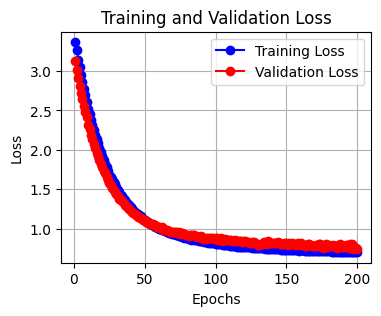


Fold 4 training...
Train: 		14446 samples for 1086 patients with imbalance ratio 0.5
Validation: 	1779 samples for 271 patients with imbalance ratio 0.04441
Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - loss: 22.2640 - val_val loss: 81.0988
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - loss: 21.2641 - val_val loss: 86.7090
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 19.4255 - val_val loss: 95.9606
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 16.8684 - val_val loss: 81.8301
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 13.9503 - val_val loss: 74.6974
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - loss: 11.1648 - val_val loss: 45.1851
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - loss: 8.6753 - val_val loss: 26.4200
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 6.6823 - val_val loss: 18.8467
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 5.3791 - val_val loss: 16.0026

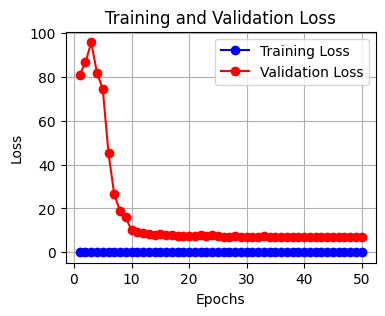

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
Epoch 1/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - auc_5: 0.4901 - loss: 3.3407 - precision_5: 0.4954 - recall_5: 0.4954 - val_auc_5: 0.8811 - val_loss: 2.7746 - val_precision_5: 0.8718 - val_recall_5: 0.8718
Epoch 2/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - auc_5: 0.4921 - loss: 3.2157 - precision_5: 0.4974 - recall_5: 0.4974 - val_auc_5: 0.8895 - val_loss: 2.6630 - val_precision_5: 0.8966 - val_recall_5: 0.8966
Epoch 3/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - auc_5: 0.4909 - loss: 3.1023 - precision_5: 0.4863 - recall_5: 0.4863 - val_auc_5: 0.8873 - val_loss: 2.5699 - val_precision_5: 0.8943 - val_recall_5: 0.8943
Epoch 4/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - auc_5: 0.4949 - loss: 2.9883 - precision_5: 0.4935 - recall_5: 0.4935 - val_auc_5: 0.8887 - val_loss: 2.4723 - val_precision_5: 0.8893 - val_recall_5: 0.8893
Epoch 5/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - auc_5: 0.5006 - loss: 2.8806 - precision_5:

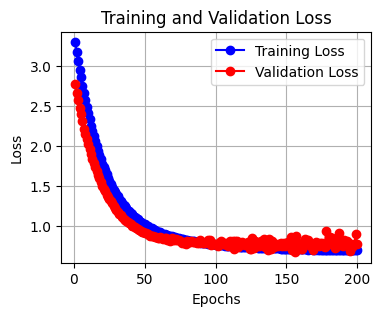


Fold 5 training...
Train: 		14396 samples for 1086 patients with imbalance ratio 0.5
Validation: 	1803 samples for 271 patients with imbalance ratio 0.04326
Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - loss: 22.2427 - val_val loss: 80.7682
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 21.2945 - val_val loss: 88.4052
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 19.5231 - val_val loss: 88.6226
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 16.9962 - val_val loss: 103.2701
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - loss: 14.1020 - val_val loss: 105.4953
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 11.2263 - val_val loss: 67.8166
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 8.6674 - val_val loss: 49.6970
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 6.7083 - val_val loss: 32.6817
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 5.3913 - val_val loss: 29.73

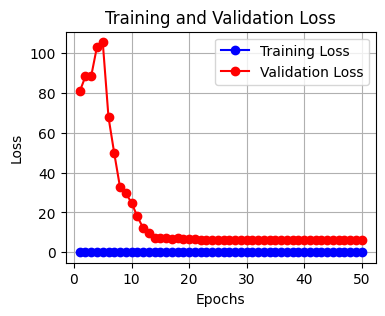

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - auc_6: 0.4944 - loss: 3.3852 - precision_6: 0.4898 - recall_6: 0.4898 - val_auc_6: 0.3317 - val_loss: 3.2823 - val_precision_6: 0.0926 - val_recall_6: 0.0926
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - auc_6: 0.4933 - loss: 3.2658 - precision_6: 0.4925 - recall_6: 0.4925 - val_auc_6: 0.3318 - val_loss: 3.1820 - val_precision_6: 0.0849 - val_recall_6: 0.0849
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - auc_6: 0.5002 - loss: 3.1475 - precision_6: 0.5044 - recall_6: 0.5044 - val_auc_6: 0.3330 - val_loss: 3.0567 - val_precision_6: 0.0876 - val_recall_6: 0.0876
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - auc_6: 0.5071 - loss: 3.0382 - precision_6: 0.5121 - recall_6: 0.5121 - val_auc_6: 0.3331 - val_loss: 2.9471 - val_precision_6: 0.0876 - val_recall_6: 0.0876
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - auc_6: 0.5046 - loss: 2.9337 - precision_6:

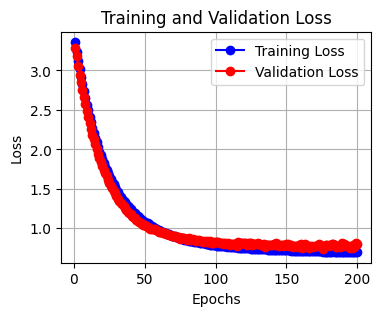


Cross-validation metrics summary:


,num_train_sample,num_train_patient,num_val_sample,num_val_patient,precision,recall,f1_score,auc(PR),specificity,tn,fp,fn,tp,reconstruct_error
1,14158.0,1085.0,1923.0,272.0,0.047252,0.620253,0.087814,0.561499,0.464208,856.0,988.0,30.0,49.0,6.369861
2,14178.0,1085.0,1913.0,272.0,0.043912,0.556962,0.081406,0.516813,0.477644,876.0,958.0,35.0,44.0,6.655287
3,14206.0,1086.0,1898.0,271.0,0.043197,0.512821,0.079681,0.538955,0.513187,934.0,886.0,38.0,40.0,6.600450
4,14446.0,1086.0,1779.0,271.0,0.047091,0.645570,0.087780,0.556750,0.392941,668.0,1032.0,28.0,51.0,6.436116
5,14396.0,1086.0,1803.0,271.0,0.047410,0.692308,0.088743,0.580654,0.371014,640.0,1085.0,24.0,54.0,6.519011
Average,14276.8,1085.6,1863.2,271.4,0.045772,0.605583,0.085085,0.550934,0.443799,794.8,989.8,31.0,47.6,6.516145


In [ ]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from keras import optimizers
import pandas as pd
import numpy as np

# Initialize metrics dictionary
metrics = {
    'num_train_sample': [], 'num_train_patient': [], 'num_val_sample': [], 'num_val_patient': [],
    'precision': [], 'recall': [], 'f1_score': [], 'auc(PR)': [], 'specificity': [],
    'tn': [], 'fp': [], 'fn': [], 'tp': [],
    'reconstruct_error': []  # Metric to track reconstruction error
}

# Stratified 5-Fold Cross-Validation based on patient (HADM_ID)
skf = StratifiedKFold(n_splits=5)
sepsis_patient_df = train_df.groupby('subject_id').Label.max().reset_index()

i = 0
for train_index, val_index in skf.split(sepsis_patient_df.subject_id, sepsis_patient_df.Label):
    i += 1
    print(f"\nFold {i} training...")

    # Prepare training and validation data
    (X_train, mask_train, y_train), (X_val, mask_val, y_val) = prepare_data_for_training(
        train_df, sepsis_patient_df, train_index, val_index, metrics)
    # X_train_normalized = (X_train - np.mean(X_train)) / np.std(X_train)
    # X_val_normalized = (X_val - np.mean(X_val)) / np.std(X_val)

    # Fill NaN values with 0
    X_train = np.nan_to_num(X_train, nan=-1)
    X_val = np.nan_to_num(X_val, nan=-1)

    # Stage 1: Reconstruction Model
    # Instantiate autoencoder models
    encoder, decoder, autoencoder = AutoEncoder_model(X_train.shape[1], X_train.shape[2], drop_r=0.5)

    # Compile and train autoencoder
    training = WeightedMaskAutoEncFit(autoencoder, mask_weight_para=0.8)
    training.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
                     loss=element_wise_weight_mae)
    history = training.fit(X_train, mask_train,
                           validation_data=(X_val, mask_val),
                           batch_size=64, epochs=50, verbose=1)

    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, val_loss_name='val_val loss')

    # Evaluate reconstruction error
    y_pred = autoencoder.predict(X_val)
    reconstruct_error = element_wise_weight_mae(X_val, y_pred).numpy()
    metrics['reconstruct_error'].append(reconstruct_error)


    # Stage 2: Classification Model
    input_shape = X_train.shape[1:]  # Infer input shape
    classification_model = classification((X_train.shape[1], X_train.shape[2]), encoder)

    # Compile classification model with metrics for imbalanced classification
    opt = optimizers.Adam(learning_rate=1e-5)
    classification_model.compile(optimizer=opt,
                                 loss='binary_crossentropy',
                                 metrics=[tf.keras.metrics.Precision(),
                                          tf.keras.metrics.Recall(),
                                          tf.keras.metrics.AUC(curve='PR')])
    # Train classification model
    history = classification_model.fit(X_train, y_train,
                                       validation_data=(X_val, y_val),
                                       epochs=200, batch_size=32, verbose=1)

    # Evaluate classification model
    y_val_pred_probs = classification_model.predict(X_val)
    y_val_true = np.argmax(y_val, axis=1)

    # Use the evaluation function to update metrics
    fold_metrics = evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # Plot learning curves for the classification model
    plot_learning_curves(history)

    # break

# Summarize cross-validation metrics
print("\nCross-validation metrics summary:")
metrics_df = pd.DataFrame(metrics)
metrics_df.index = range(1, len(metrics_df) + 1)
metrics_df.loc['Average', :] = metrics_df.mean(numeric_only=True)
display(metrics_df)
